# Look at SNP removal Experiment

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import h5py
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import Colormap as cm
from scipy.stats import spearmanr

sys.path.append("/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/DIETNETWORK/")
sys.path.append("/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/DIETNETWORK/Dietnet")
import helpers.dataset_utils as du
from helpers import mainloop_utils as mlu
import helpers.model as model
import helpers.log_utils as lu
from Interpretability import graph_attribution_manager as gam
from Interpretability import utils


os.environ["CUDA_VISIBLE_DEVICES"] = "5,6"
device = torch.device('cuda:0')

In [2]:
#exp_path = Path('/home/mattscicluna/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments/remove_largest_attr_zero_baseline')        # zero-baseline experiment
exp_path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments/remove_largest_attr_enc_0_baseline_all_folds')     # encoded zero-baseline experiment
#exp_path = Path('/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/EXP_DIETNET2/DEBUG/TEMP/')                                          # old location

In [75]:
# can load results here
exp_data = pd.read_csv('full_results_exp.csv')

In [4]:
def compare_attr_between_iters(index1, index2, which_fold, exp_path):
    ###################################################
    #############   attribution at index1 #############
    ###################################################

    exp_name = 'remove_attr_exp_{}'.format(index1)
    dataset = 'dataset-{}.npz'.format(index1)

    exp_path = Path(exp_path)
    full_path = exp_path / exp_name 
    full_path = full_path / '{}_fold{}/'.format(exp_name, which_fold)

    #print('Loading data')
    # Load samples, snp names and genotype values
    #data = du.load_data(os.path.join(exp_path, dataset))

    hf = h5py.File(os.path.join(full_path, 'attrs_avg.h5'), 'r')
    agg_attr1 = hf['avg_attr'][:, :, :]
    feat_names1 = np.load(os.path.join(full_path, 'additional_data.npz'))['feature_names']

    ###################################################
    #############  attribution at index2  #############
    ###################################################

    exp_name = 'remove_attr_exp_{}'.format(index2)
    dataset = 'dataset-{}.npz'.format(index2)

    exp_path = Path(exp_path)
    full_path = exp_path / exp_name 
    full_path = full_path / '{}_fold{}/'.format(exp_name, which_fold)

    hf = h5py.File(os.path.join(full_path, 'attrs_avg.h5'), 'r')
    agg_attr2 = hf['avg_attr'][:, :, :]
    feat_names2 = np.load(os.path.join(full_path, 'additional_data.npz'))['feature_names']
    feat_size = agg_attr2.shape[0]

    to_keep = np.full(feat_names1.shape, False)

    # reverse engineer which SNPs were removed
    j = 0
    for i in range(feat_names1.shape[0]):
        if j == feat_names2.shape[0]:
            break
        if feat_names1[i] == feat_names2[j]:
            to_keep[i] = True
            j += 1
        else:
            to_keep[i] = False
    assert (feat_names1[to_keep] == feat_names2).all()

    results = utils.get_corr_each(agg_attr1[to_keep], agg_attr2, utils.get_spearman_correlation, use_abs=False)
    print('[fold {}] feat size: {} attr spearman corr: {} +/- {}'.format(which_fold, feat_size, results[0][[1,2]].mean(), results[0][[1,2]].std()))
    return results, feat_size

## Make Table (Ignore this if Loading from line above)

In [ ]:
exp_data = pd.DataFrame(columns=['feat size', 'fold', 'accuracy', 'num epochs'])

for index in range(21):
    exp_name = "remove_attr_exp_{}".format(index)
    genotypes = "dataset-{}.npz".format(index)
    dataset = "dataset-{}.npz".format(index)
    embedding = "embedding-{}.npz".format(index)

    full_path = exp_path / exp_name 
    full_paths = [full_path / '{}_fold{}/'.format(exp_name, which_fold) for which_fold in range(5)]

    model_preds = [np.load(full_path / 'model_predictions.npz') for full_path in full_paths]
    additional_data = [np.load(full_path / 'additional_data.npz') for full_path in full_paths]

    epochs = np.array([model_pred['n_epochs'] for model_pred in model_preds])
    accuracy = np.array([(model_pred['test_preds'] == model_pred['test_labels']).mean() for model_pred in model_preds])
    feat_size = np.array([adata['feature_names'].shape[0] for adata in additional_data])
    exp_data = pd.concat([exp_data, pd.DataFrame({'feat size': feat_size, 'fold': list(range(5)), 'accuracy': accuracy, 'num epochs': epochs})], ignore_index=True)

In [ ]:
exp_data2 = pd.DataFrame(columns=['feat size', 'fold', 'mean attr spearman corr', 'std attr spearman corr'])

for index in range(20): # one less since comparing index with index+1

    for which_fold in range(5):
        results, feat_size = compare_attr_between_iters(index, index+1, which_fold, exp_path)
        exp_data2 = exp_data2.append({'feat size': int(feat_size), 'fold': int(which_fold), 'mean attr spearman corr': results[0][[1,2]].mean(), 'std attr spearman corr': results[0][[1,2]].std()}, ignore_index=True)

In [ ]:
#exp_data2.fold=exp_data2.fold.astype('int')
exp_data = exp_data.merge(exp_data2, on=['feat size', 'fold'], how='outer')
exp_data.to_csv('full_results_exp.csv')

## Lets look at how the accuracy changes during the duration of the experiment

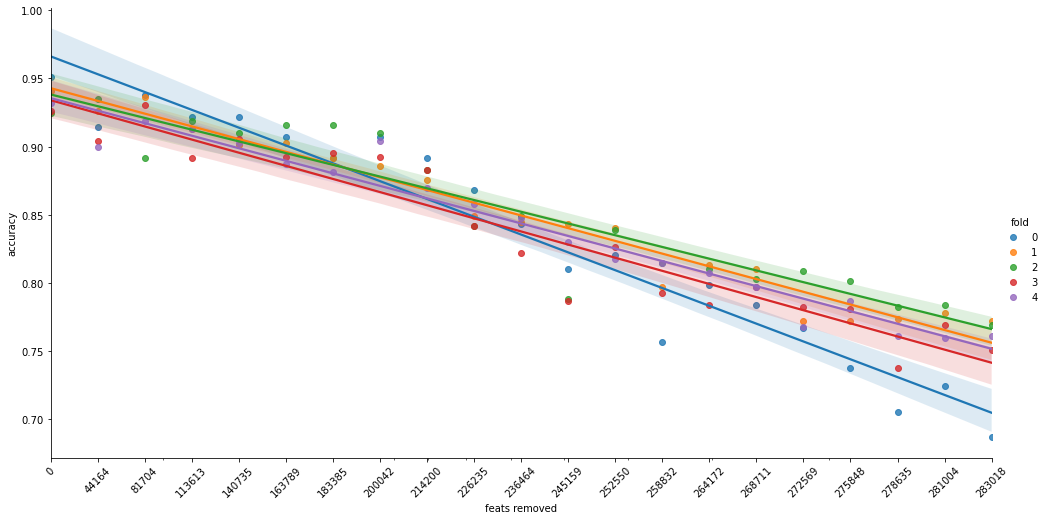

In [5]:
def make_nice_plot(x, y, hue, df, plot_func=sns.lmplot, **kwargs):
    fig = plot_func(x=x, y=y, hue=hue, ci=95, data=df, **kwargs)

    #  some plot functions in seaborn don't work with log
    #  some have axis structure != 2D
    axes = fig.axes
    #axes[0,0].set_xlim(0, 300000)
    axes[0,0].set_xscale('log')
    axes[0,0].set_xticks(exp_data['feat size'].unique())
    axes[0,0].invert_xaxis()
    axes[0,0].get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    axes[0,0].set_xticklabels(exp_data['feat size'].max()-exp_data['feat size'].unique())
    axes[0,0].set(xlabel='feats removed')

    plt.xticks(rotation=45)

make_nice_plot(x='feat size', y='accuracy', hue='fold', df=exp_data, logx=True, height=7, aspect=2)

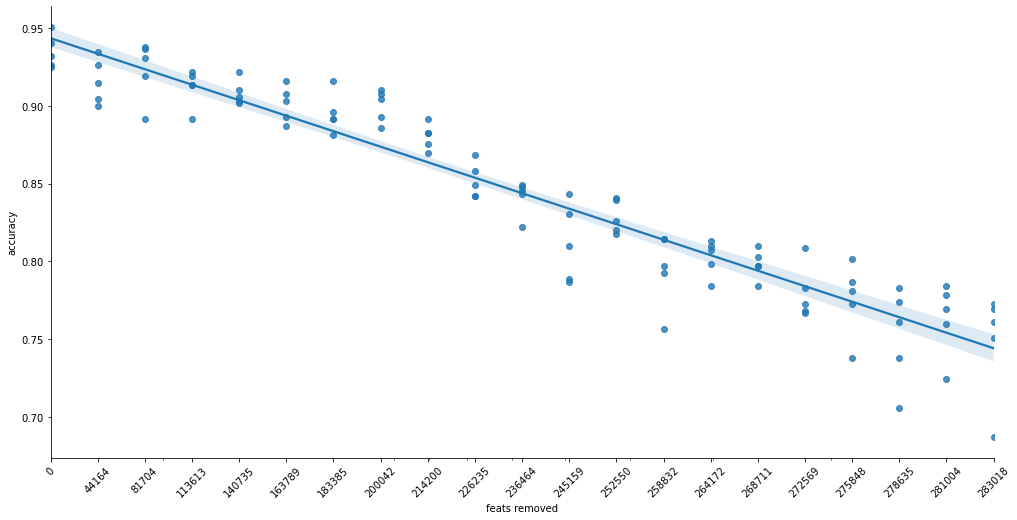

In [6]:
make_nice_plot(x='feat size', y='accuracy', hue=None, df=exp_data, logx=True, height=7, aspect=2)

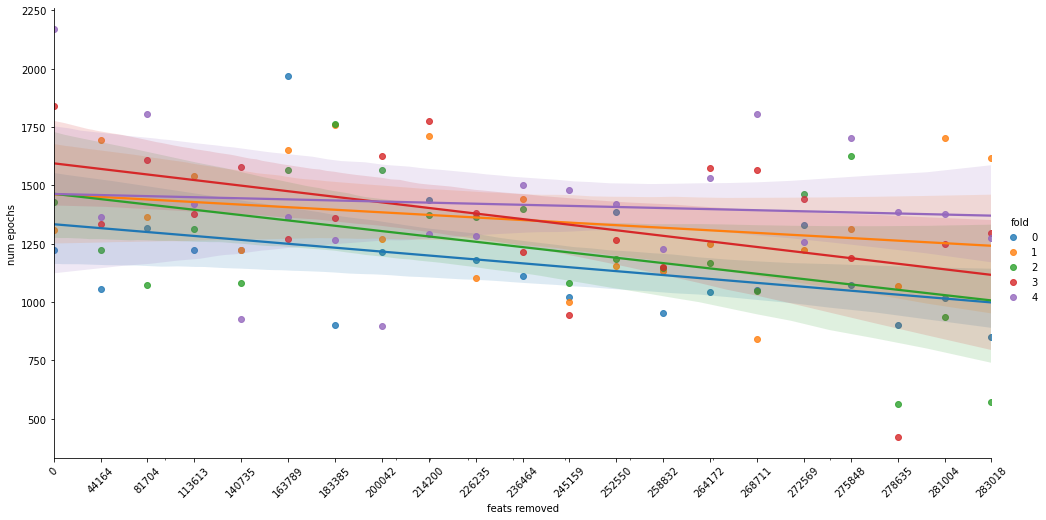

In [7]:
make_nice_plot(x='feat size', y='num epochs', hue='fold', df=exp_data, logx=True, height=7, aspect=2)

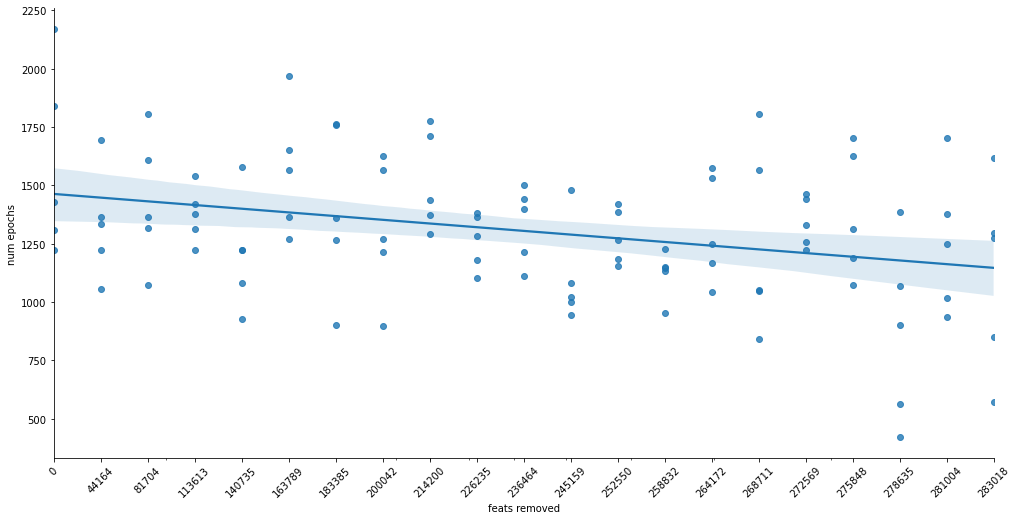

In [8]:
make_nice_plot(x='feat size', y='num epochs', hue=None, df=exp_data, logx=True, height=7, aspect=2)

##  Analyze How Attributions are Correlated Between Runs

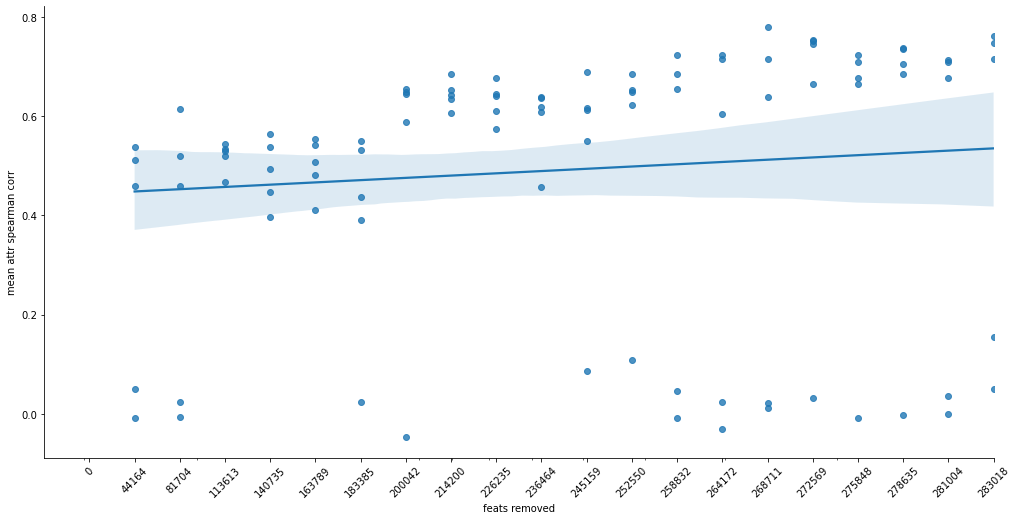

In [10]:
make_nice_plot(x='feat size', y='mean attr spearman corr', hue=None, logx=True, height=7, aspect=2, df=exp_data)

##  Lets see how each fold behaves!

(array([294427, 250263, 212723, 180814, 153692, 130638, 111042,  94385,
         80227,  68192,  57963,  49268,  41877,  35595,  30255,  25716,
         21858,  18579,  15792,  13423,  11409]),
 <a list of 21 Text major ticklabel objects>)

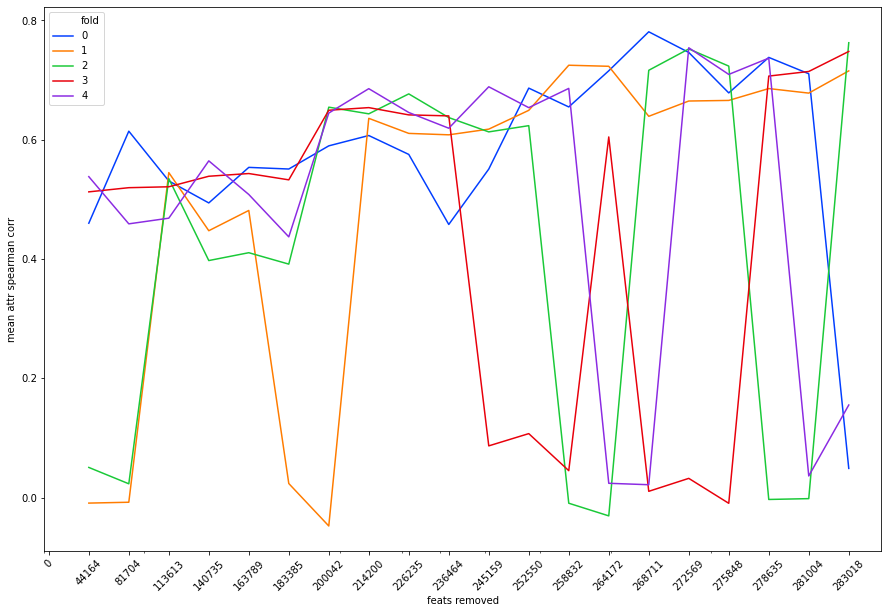

In [13]:
#make_nice_plot(x='feat size', y='mean attr spearman corr', hue='fold', df=exp_data, plot_func=sns.lineplot)

fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='feat size', y='mean attr spearman corr', hue='fold', data=exp_data, ci=95, ax=ax, palette=sns.color_palette("bright", 5))

ax.set_xlim(10000, 300000)
ax.set_xscale('log')
ax.set_xticks(exp_data['feat size'].unique())
ax.invert_xaxis()
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticklabels(exp_data['feat size'].max()-exp_data['feat size'].unique())
ax.set(xlabel='feats removed')


plt.xticks(rotation=45)

In [14]:
exp_data3 = pd.DataFrame(columns=['feat size', 'fold', 'i1', 'i2', 'mean attr spearman corr', 'std attr spearman corr'])

# When network does a one-step "decorrelatation", does it "regain" the same mapping after?
spots_to_check = {
    1: [(0,2), (5,7)],
    2: [(0,2), (12,14), (17,19)],
    4: [(13,15)]
}

# When the networks undergo a one-step "decorrelatation", is that decorrelated network correlated to other decorrelated networks?
spots_to_check2 = {
    1: [(1,6)],
    2: [(1,12),(12,17), (1,17)]
}
 
for which_fold in spots_to_check.keys():

    for index1, index2 in spots_to_check[which_fold]:
        results, feat_size = compare_attr_between_iters(index1, index2, which_fold, exp_path)
        exp_data3 = exp_data3.append({'feat size': int(feat_size), 
                                      'fold': int(which_fold), 
                                      'i1': index1, 
                                      'i2': index2,
                                      'mean attr spearman corr': results[0][[1,2]].mean(), 
                                      'std attr spearman corr': results[0][[1,2]].std()}, ignore_index=True)

for which_fold in spots_to_check2.keys():

    for index1, index2 in spots_to_check2[which_fold]:
        results, feat_size = compare_attr_between_iters(index1, index2, which_fold, exp_path)
        exp_data3 = exp_data3.append({'feat size': int(feat_size), 
                                      'fold': int(which_fold), 
                                      'i1': index1, 
                                      'i2': index2,
                                      'mean attr spearman corr': results[0][[1,2]].mean(), 
                                      'std attr spearman corr': results[0][[1,2]].std()}, ignore_index=True)

[fold 1] feat size: 212723 attr spearman corr: 0.43422242228944274 +/- 0.23385385014609414


/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/scipy/stats/stats.py:4201: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


[fold 1] feat size: 94385 attr spearman corr: 0.45522169334067725 +/- 0.18805302194012255
[fold 2] feat size: 212723 attr spearman corr: 0.3981895977944776 +/- 0.15361896302572894
[fold 2] feat size: 30255 attr spearman corr: 0.6411840219956513 +/- 0.12183439405036717
[fold 2] feat size: 13423 attr spearman corr: 0.6638045784109649 +/- 0.08502961402033854
[fold 4] feat size: 25716 attr spearman corr: 0.6482920536648433 +/- 0.11563820673496056
[fold 1] feat size: 111042 attr spearman corr: 0.5950678144781857 +/- 0.37246440790986657
[fold 2] feat size: 41877 attr spearman corr: 0.019515094143305926 +/- 0.10555149466359146
[fold 2] feat size: 18579 attr spearman corr: 0.6007277671408688 +/- 0.12109051424126586
[fold 2] feat size: 18579 attr spearman corr: 0.04068658111532705 +/- 0.09812929821964647


In [15]:
exp_data3.to_csv('full_results_exp_explore_dips.csv')

## Lets compare the correlation of output predictions/logits at these points as well!

In [96]:
def compare_corr_between_iters(index1, index2, which_fold, exp_path):
    ###################################################
    #############   attribution at index1 #############
    ###################################################
    exp_name = 'remove_attr_exp_{}'.format(index1)

    exp_path = Path(exp_path)
    full_path = exp_path / exp_name 
    full_path = full_path / '{}_fold{}/'.format(exp_name, which_fold)

    test_scores1 = np.load(os.path.join(full_path, 'additional_data.npz'))['test_scores']


    ###################################################
    #############  attribution at index2  #############
    ###################################################

    exp_name = 'remove_attr_exp_{}'.format(index2)

    exp_path = Path(exp_path)
    full_path = exp_path / exp_name 
    full_path = full_path / '{}_fold{}/'.format(exp_name, which_fold)

    test_scores2 = np.load(os.path.join(full_path, 'additional_data.npz'))['test_scores']
    corrs_per_sample = np.array([spearmanr(test_scores1[i], test_scores2[i], axis=1, nan_policy='omit')[0] for i in range(test_scores1.shape[0])])

    feat_size = np.load(os.path.join(exp_path, 'dataset-{}.npz'.format(index2)))['inputs'].shape[1]
    print('[fold {}] feat size: {} attr spearman corr: {} +/- {}'.format(which_fold, feat_size, corrs_per_sample.mean(), corrs_per_sample.std()))

    return corrs_per_sample, feat_size

In [97]:
corr_preds_btw_iters = pd.DataFrame(columns=['feat size', 'fold', 'mean pred corrs', 'std pred corrs'])

for index in range(20): # one less since comparing index with index+1
    for which_fold in range(5):
        results, feat_size = compare_corr_between_iters(index, index+1, which_fold, exp_path)
        corr_preds_btw_iters = corr_preds_btw_iters.append({'feat size': int(feat_size), 
                                                            'fold': int(which_fold), 
                                                            'mean pred corrs': results.mean(), 
                                                            'std pred corrs': results.std()}, ignore_index=True)

[fold 0] feat size: 250263 attr spearman corr: 0.8401981915025393 +/- 0.06825930339264197
[fold 1] feat size: 250263 attr spearman corr: 0.8836021305586522 +/- 0.05252831031708834
[fold 2] feat size: 250263 attr spearman corr: 0.8622529419051156 +/- 0.08621992832249699
[fold 3] feat size: 250263 attr spearman corr: 0.8784313142574012 +/- 0.057533440301994025
[fold 4] feat size: 250263 attr spearman corr: 0.8842393162393162 +/- 0.04632424348897573
[fold 0] feat size: 212723 attr spearman corr: 0.8452471200297287 +/- 0.07964710834021456
[fold 1] feat size: 212723 attr spearman corr: 0.8568978075065032 +/- 0.0775425108250952
[fold 2] feat size: 212723 attr spearman corr: 0.8741771336553945 +/- 0.05149730339715864
[fold 3] feat size: 212723 attr spearman corr: 0.8346280193236715 +/- 0.0792354898295849
[fold 4] feat size: 212723 attr spearman corr: 0.8708207605598908 +/- 0.06504549455949524
[fold 0] feat size: 180814 attr spearman corr: 0.8671512448903754 +/- 0.0687452658496809
[fold 1] fea

In [99]:
exp_data = exp_data.merge(corr_preds_btw_iters, on=['feat size', 'fold'], how='outer')
exp_data.to_csv('full_results_exp.csv')

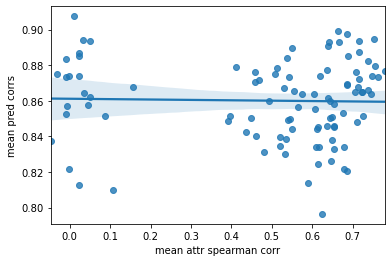

In [113]:
sns.regplot(x='mean attr spearman corr', y='mean pred corrs', data=exp_data)